# Amazon Fine Food Reviews Analysis - KNN Application


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




## [7.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

In [2]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Featurization", "Hyper parameter(K)", "Train Error %", "Test Error %"]

In [3]:

# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 
#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 


# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


#  Exploratory Data Analysis

## [7.1.2] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [4]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As can be seen above the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [5]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [6]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

In [7]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [9]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [10]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(364171, 10)


1    307061
0     57110
Name: Score, dtype: int64

In [11]:
#Deduplication of entries
#final=sorted_data.drop_duplicates(subset={"Score"}, keep='first', inplace=False)
#final.shape

final_pos_reviews=final.loc[final['Score'] == 1]
final_neg_reviews=final.loc[final['Score']== 0]

In [12]:
final_new=final.sample(n=80000)

final=final.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

labels = final_new['Score']


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate

In [14]:
new_final=final_new.sort_values('Time')
final=new_final
new_labels=final['Score']

## 7.2.3  Text Preprocessing: Stemming, stop-word removal and Lemmatization.

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# find sentences containing HTML tags
import re
i=0;
for sent in final['Text'].values:
    if (len(re.findall('<.*?>', sent))):
        print(i)
        print(sent)
        break;
    i += 1;

7
When Two Couple (Geena Davis & Alec Baldwin) died in a car accident but they come back alive as Ghosts, they are Stuck for eternity inside thier house. Months later, a New York Family (Winona Ryder, Jeffery Jones & Catherine O` Hara) move to a Little Connecticut Farmhouse, changing the house aesthetically. The Ghostly Couple are forced to call a Out of Control Troublemaker named Beetlejuice (Played in a Over the Top Role by Micheal Keaton) to get the new Family out of thier home.<p>Directed by Tim Burton (Batman, Batman Returns, Ed Wood) made a entertaining delightful silly fantasy comedy with unique Visual Effects and a terrific music score by Danny Elfman. A Box Office Hit in the Summer of 1988. The film has Plenty of Energy, Style and Humor. Danny Elfman win an Oscar for his Unique Score. A Extremely likeable film for all ages. Grade:A-.


In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ksumanth01/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:

stop = set(stopwords.words('english')) #set of stopwords
sno = nltk.stem.SnowballStemmer('english') #initialising the snowball stemmer

def cleanhtml(sentence): #function to clean the word of any html-tags
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', sentence)
    return cleantext
def cleanpunc(sentence): #function to clean the word of any punctuation or special characters
    cleaned = re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned
print(stop)
print('************************************')
print(sno.stem('tasty'))

{'she', 'there', 'once', 'o', 'themselves', 'weren', 'did', "didn't", 'some', 'couldn', "you're", 'its', 'if', 'nor', 'when', 'just', "hadn't", "that'll", 'itself', 'who', 'how', 'most', 'aren', 'being', 'your', "you'll", 'his', 'our', 'very', "mustn't", "should've", 'haven', "won't", 'own', 'i', 'both', 'mustn', 'which', 'too', 'in', 'you', 'been', 'these', 'can', 'into', 'he', "shan't", "haven't", 'where', 't', 'below', 'other', "wouldn't", 'more', 'now', 'same', 'am', 'have', 'and', 'from', "it's", 'doesn', 'mightn', 'be', 'few', 'above', 'on', 'over', 'don', 've', 'hasn', 'hers', 'we', 'only', 'is', 'under', 'not', 'myself', 'needn', 'my', 'during', 'no', "don't", 'at', 'out', 'was', 'll', 'm', 'about', 'further', 'all', 're', 'ain', 'herself', 'of', 'won', 'yours', 'has', "doesn't", 'didn', 'what', 'yourselves', 'isn', 'shan', 'an', 'but', 'me', 'up', 'do', 'y', 'are', 's', 'having', 'them', "you'd", "aren't", 'again', 'than', 'ma', 'it', 'why', "wasn't", 'so', 'down', "shouldn't"

In [18]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
# this code takes a while to run as it needs to run on 500k sentences.
if not os.path.isfile('final.sqlite'):
    i=0
    str1=' '
    final_string=[]
    all_positive_words=[] # store words from +ve reviews here
    all_negative_words=[] # store words from -ve reviews here.
    s=''
    for sent in tqdm(final['Text'].values):
        filtered_sentence=[]
        #print(sent);
        sent=cleanhtml(sent) # remove HTMl tags
        for w in sent.split():
            for cleaned_words in cleanpunc(w).split():
                if((cleaned_words.isalpha()) & (len(cleaned_words)>2)):    
                    if(cleaned_words.lower() not in stop):
                        s=(sno.stem(cleaned_words.lower())).encode('utf8')
                        filtered_sentence.append(s)
                        if (final['Score'].values)[i] == 'positive': 
                            all_positive_words.append(s) #list of all words used to describe positive reviews
                        if(final['Score'].values)[i] == 'negative':
                            all_negative_words.append(s) #list of all words used to describe negative reviews reviews
                    else:
                        continue
                else:
                    continue 
        #print(filtered_sentence)
        str1 = b" ".join(filtered_sentence) #final string of cleaned words
        #print("***********************************************************************")

        final_string.append(str1)
        i+=1

    #############---- storing the data into .sqlite file ------########################
    final['CleanedText']=final_string #adding a column of CleanedText which displays the data after pre-processing of the review 
    final['CleanedText']=final['CleanedText'].str.decode("utf-8")
        # store final table into an SQlLite table for future.
    conn = sqlite3.connect('final.sqlite')
    c=conn.cursor()
    conn.text_factory = str
    final.to_sql('Reviews', conn,  schema=None, if_exists='replace', \
                 index=True, index_label=None, chunksize=None, dtype=None)
    conn.close()
    
    
    with open('positive_words.pkl', 'wb') as f:
        pickle.dump(all_positive_words, f)
    with open('negitive_words.pkl', 'wb') as f:
        pickle.dump(all_negative_words, f)

In [19]:
if os.path.isfile('final.sqlite'):
    conn = sqlite3.connect('final.sqlite')
    final = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, conn)
    conn.close()
else:
    print("Please the above cell")

# Bag of Words - Unigrams

<class 'scipy.sparse.csr.csr_matrix'>
(39200, 24484)


  0%|          | 0/21 [00:00<?, ?it/s]

<class 'scipy.sparse.csr.csr_matrix'>
(16800, 24484)


  5%|▍         | 1/21 [00:38<12:59, 38.96s/it]

CV weighted f1 for k = 5 is 77.771789%


 10%|▉         | 2/21 [01:15<12:06, 38.26s/it]

CV weighted f1 for k = 7 is 77.071900%


 14%|█▍        | 3/21 [01:53<11:25, 38.09s/it]

CV weighted f1 for k = 11 is 76.165593%


 19%|█▉        | 4/21 [02:29<10:38, 37.58s/it]

CV weighted f1 for k = 13 is 75.903126%


 24%|██▍       | 5/21 [03:05<09:54, 37.13s/it]

CV weighted f1 for k = 17 is 75.430700%


 29%|██▊       | 6/21 [03:42<09:15, 37.05s/it]

CV weighted f1 for k = 19 is 75.300939%


 33%|███▎      | 7/21 [04:18<08:35, 36.84s/it]

CV weighted f1 for k = 23 is 75.113927%


 38%|███▊      | 8/21 [04:54<07:55, 36.59s/it]

CV weighted f1 for k = 29 is 74.978790%


 43%|████▎     | 9/21 [05:32<07:20, 36.74s/it]

CV weighted f1 for k = 31 is 74.919047%


 48%|████▊     | 10/21 [06:08<06:43, 36.65s/it]

CV weighted f1 for k = 37 is 74.814194%


 52%|█████▏    | 11/21 [06:45<06:08, 36.86s/it]

CV weighted f1 for k = 41 is 74.817176%


 57%|█████▋    | 12/21 [07:22<05:31, 36.84s/it]

CV weighted f1 for k = 43 is 74.831444%


 62%|██████▏   | 13/21 [07:59<04:54, 36.80s/it]

CV weighted f1 for k = 47 is 74.831444%


 67%|██████▋   | 14/21 [08:36<04:19, 37.01s/it]

CV weighted f1 for k = 53 is 74.774322%


 71%|███████▏  | 15/21 [09:14<03:44, 37.33s/it]

CV weighted f1 for k = 59 is 74.774322%


 76%|███████▌  | 16/21 [09:51<03:05, 37.16s/it]

CV weighted f1 for k = 61 is 74.760022%


 81%|████████  | 17/21 [10:28<02:28, 37.09s/it]

CV weighted f1 for k = 67 is 74.777292%


 86%|████████▌ | 18/21 [11:06<01:51, 37.21s/it]

CV weighted f1 for k = 71 is 74.762987%


 90%|█████████ | 19/21 [11:43<01:14, 37.36s/it]

CV weighted f1 for k = 76 is 74.762987%


 95%|█████████▌| 20/21 [12:21<00:37, 37.35s/it]

CV weighted f1 for k = 79 is 74.777292%


100%|██████████| 21/21 [12:57<00:00, 37.19s/it]

CV weighted f1 for k = 90 is 74.748675%
Best K:  5


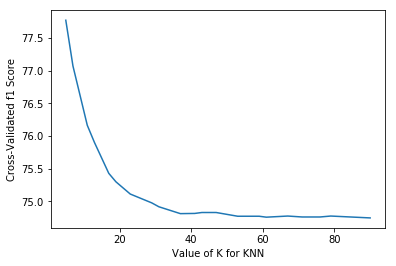

In [23]:
# Dividing raw train and test data
from sklearn.metrics import f1_score
X = final['CleanedText']
y = np.array(new_labels)

X_train = X[:int(0.7*len(X))]
y_train = y[:int(0.7*len(y))]
X_test = X[len(X_train):]
y_test = y[len(y_train):]

X_cv = X_train[:int(0.7*len(X_train))]
y_cv = y_train[:int(0.7*len(y_train))]
X_cv_test = X_train[len(X_cv):]
y_cv_test = y_train[len(y_cv):]

# Applying bow on train data
count_vect = CountVectorizer()
cv_train_final = count_vect.fit_transform(X_cv)
cv_train_voc = count_vect.vocabulary_
print(type(cv_train_final))
print(cv_train_final.get_shape())

count_vect1 = CountVectorizer(vocabulary = cv_train_voc)
cv_test_final = count_vect1.fit_transform(X_cv_test)
print(type(cv_test_final))
print(cv_test_final.get_shape())

# Preparing list with possible K-values
neighbors = [5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 76, 79, 90]
cv_f1_scores  = []

# Brute force KNN
for i in tqdm(neighbors):
  knn = KNeighborsClassifier(n_neighbors=i, algorithm='brute')
  knn.fit(cv_train_final, y_cv)
  pred = knn.predict(cv_test_final)
  f1 = f1_score(y_cv_test, pred, average='weighted')*100
  cv_f1_scores.append(f1)
  print('CV weighted f1 for k = %d is %f%%' % (i, f1))
  
plt.plot(neighbors, cv_f1_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated f1 Score')

best_k = neighbors[cv_f1_scores.index(max(cv_f1_scores))]
print('Best K: ',best_k)
train_error = round((100-max(cv_f1_scores)),4)

<class 'scipy.sparse.csr.csr_matrix'>
(56000, 28735)
<class 'scipy.sparse.csr.csr_matrix'>
(24000, 28735)
Weighted f1-score for k= 5  is  76.7750689166399 %
Confusion matrix : 
[[  366  3933]
 [  254 19447]]


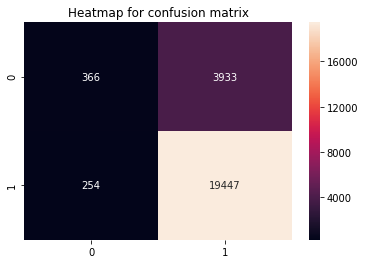

In [24]:
count_vect2 = CountVectorizer()
X_train_final = count_vect2.fit_transform(X_train)
X_train_voc = count_vect2.vocabulary_
print(type(X_train_final))
print(X_train_final.get_shape())

count_vect3 = CountVectorizer(vocabulary = X_train_voc)
X_test_final = count_vect3.fit_transform(X_test)
print(type(X_test_final))
print(X_test_final.get_shape())

knn = KNeighborsClassifier(n_neighbors=best_k, algorithm='brute')
knn.fit(X_train_final, y_train)
pred = knn.predict(X_test_final)
f1 = f1_score(y_test, pred, average='weighted')*100
test_error = round((100-f1),4)
confusion = confusion_matrix(y_test, pred)
print('Weighted f1-score for k=',best_k,' is ',f1,'%')
print('Confusion matrix : ')
print(confusion)
import seaborn as sns
ax = sns.heatmap(confusion, annot=True, fmt="d") 
ax.set_title('Heatmap for confusion matrix')

x.add_row(["BoW - Brute force ", best_k, train_error, test_error])

<class 'scipy.sparse.csr.csr_matrix'>
(39200, 24484)
<class 'scipy.sparse.csr.csr_matrix'>
(16800, 24484)


  5%|▍         | 1/21 [11:42<3:54:06, 702.33s/it]

CV weighted f1 for k = 5 is 75.918814%


 10%|▉         | 2/21 [23:26<3:42:33, 702.81s/it]

CV weighted f1 for k = 7 is 75.946491%


 14%|█▍        | 3/21 [35:14<3:31:21, 704.50s/it]

CV weighted f1 for k = 11 is 75.969553%


 19%|█▉        | 4/21 [47:01<3:19:50, 705.30s/it]

CV weighted f1 for k = 13 is 75.976637%


 24%|██▍       | 5/21 [58:31<3:06:47, 700.46s/it]

CV weighted f1 for k = 17 is 75.980504%


 29%|██▊       | 6/21 [1:08:54<2:49:19, 677.27s/it]

CV weighted f1 for k = 19 is 75.980504%


 33%|███▎      | 7/21 [1:19:09<2:33:39, 658.54s/it]

CV weighted f1 for k = 23 is 75.983456%


 38%|███▊      | 8/21 [1:29:23<2:19:50, 645.42s/it]

CV weighted f1 for k = 29 is 75.983456%


 43%|████▎     | 9/21 [1:39:39<2:07:19, 636.63s/it]

CV weighted f1 for k = 31 is 75.983456%


 48%|████▊     | 10/21 [1:50:06<1:56:10, 633.67s/it]

CV weighted f1 for k = 37 is 75.983456%


 52%|█████▏    | 11/21 [2:00:28<1:45:02, 630.21s/it]

CV weighted f1 for k = 41 is 75.983456%


 57%|█████▋    | 12/21 [2:10:47<1:34:00, 626.75s/it]

CV weighted f1 for k = 43 is 75.983456%


 62%|██████▏   | 13/21 [2:21:08<1:23:21, 625.14s/it]

CV weighted f1 for k = 47 is 75.983456%


 67%|██████▋   | 14/21 [2:31:21<1:12:30, 621.43s/it]

CV weighted f1 for k = 53 is 75.983456%


 71%|███████▏  | 15/21 [2:41:12<1:01:14, 612.38s/it]

CV weighted f1 for k = 59 is 75.983456%


 76%|███████▌  | 16/21 [2:51:20<50:54, 610.91s/it]  

CV weighted f1 for k = 61 is 75.983456%


 81%|████████  | 17/21 [3:01:55<41:13, 618.27s/it]

CV weighted f1 for k = 67 is 75.983456%


 86%|████████▌ | 18/21 [3:12:55<31:31, 630.56s/it]

CV weighted f1 for k = 71 is 75.983456%


 90%|█████████ | 19/21 [3:23:42<21:10, 635.47s/it]

CV weighted f1 for k = 76 is 75.983456%


 95%|█████████▌| 20/21 [3:34:30<10:39, 639.25s/it]

CV weighted f1 for k = 79 is 75.983456%


100%|██████████| 21/21 [3:45:17<00:00, 641.82s/it]

CV weighted f1 for k = 90 is 75.983456%
Best K:  23


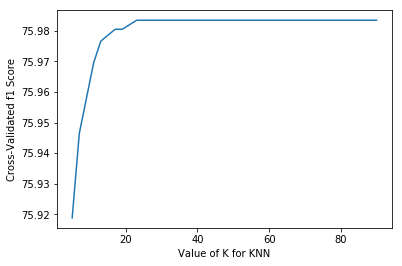

In [21]:
#kd-tree KNN for BoW

# Dividing raw train and test data
from sklearn.metrics import f1_score
X = final['CleanedText']
y = np.array(new_labels)

X_train = X[:int(0.7*len(X))]
y_train = y[:int(0.7*len(y))]
X_test = X[len(X_train):]
y_test = y[len(y_train):]

X_cv = X_train[:int(0.7*len(X_train))]
y_cv = y_train[:int(0.7*len(y_train))]
X_cv_test = X_train[len(X_cv):]
y_cv_test = y_train[len(y_cv):]

# Applying bow on train data
count_vect = CountVectorizer()
cv_train_final = count_vect.fit_transform(X_cv)
cv_train_voc = count_vect.vocabulary_
print(type(cv_train_final))
print(cv_train_final.get_shape())

# svd on cv_train
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300, n_iter=7, random_state=42)
svd.fit(cv_train_final)
svd_cv_train_final=svd.transform(cv_train_final)

# vectorizing cv_test
count_vect1 = CountVectorizer(vocabulary = cv_train_voc)
cv_test_final = count_vect1.fit_transform(X_cv_test)
print(type(cv_test_final))
print(cv_test_final.get_shape())

# svd on cv_test
svd = TruncatedSVD(n_components=300, n_iter=7, random_state=42)
svd.fit(cv_test_final)
svd_cv_test_final=svd.transform(cv_test_final)

# Preparing list with possible K-values
neighbors = [5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 76, 79, 90]
cv_f1_scores  = []

# Brute force KNN
for i in tqdm(neighbors):
  knn = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
  knn.fit(svd_cv_train_final, y_cv)
  pred = knn.predict(svd_cv_test_final)
  f1 = f1_score(y_cv_test, pred, average='weighted')*100
  cv_f1_scores.append(f1)
  print('CV weighted f1 for k = %d is %f%%' % (i, f1))
  
plt.plot(neighbors, cv_f1_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated f1 Score')

best_k = neighbors[cv_f1_scores.index(max(cv_f1_scores))]
train_error = round((100-max(cv_f1_scores)),4)
print('Best K: ',best_k)


<class 'scipy.sparse.csr.csr_matrix'>
(56000, 28735)
<class 'scipy.sparse.csr.csr_matrix'>
(24000, 28735)
Weighted f1-score for k= 23  is  74.5773787235338 %
Confusion matrix : 
[[    0  4202]
 [    0 19798]]


Text(0.5, 1.0, 'Heatmap for confusion matrix')

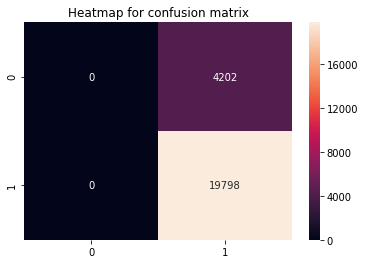

In [22]:
# vectorizing x_train
count_vect2 = CountVectorizer()
X_train_final = count_vect2.fit_transform(X_train)
X_train_voc = count_vect2.vocabulary_
print(type(X_train_final))
print(X_train_final.get_shape())

# svd on X_train
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300, n_iter=7, random_state=42)
svd.fit(X_train_final)
svd_X_train_final=svd.transform(X_train_final)

# vecotring X_test
count_vect3 = CountVectorizer(vocabulary = X_train_voc)
X_test_final = count_vect3.fit_transform(X_test)
print(type(X_test_final))
print(X_test_final.get_shape())

# svd on X_test
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300, n_iter=7, random_state=42)
svd.fit(X_test_final)
svd_X_test_final=svd.transform(X_test_final)

# appling knn k-dtree bow
knn = KNeighborsClassifier(n_neighbors=best_k, algorithm='kd_tree')
knn.fit(svd_X_train_final, y_train)
pred = knn.predict(svd_X_test_final)
f1 = f1_score(y_test, pred, average='weighted')*100

test_error = round((100-f1),4)
confusion = confusion_matrix(y_test, pred)
print('Weighted f1-score for k=',best_k,' is ',f1,'%')
print('Confusion matrix : ')
print(confusion)
x.add_row(["BoW - kd_tree ", best_k, train_error, test_error])
import seaborn as sns
ax = sns.heatmap(confusion, annot=True, fmt="d") 
ax.set_title('Heatmap for confusion matrix')

## [7.2.4] Bi-Grams and n-Grams.

**Motivation**

Now that we have our list of words describing positive and negative reviews lets analyse them.<br>

We begin analysis by getting the frequency distribution of the words as shown below

In [ ]:
with open('positive_words.pkl', 'rb') as f:
    all_positive_words = pickle.load(f)
with open('negitive_words.pkl', 'rb') as f:
    all_negative_words = pickle.load(f)
    
freq_dist_positive=nltk.FreqDist(all_positive_words)
freq_dist_negative=nltk.FreqDist(all_negative_words)
print("Most Common Positive Words : ",freq_dist_positive.most_common(20))
print("Most Common Negative Words : ",freq_dist_negative.most_common(20))

<b>Observation:-</b> From the above it can be seen that the most common positive and the negative words overlap for eg. 'like' could be used as 'not like' etc. <br>
So, it is a good idea to consider pairs of consequent words (bi-grams) or q sequnce of n consecutive words (n-grams)

In [ ]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
count_vect = CountVectorizer(ngram_range=(1,2) ) #in scikit-learn
final_bigram_counts = count_vect.fit_transform(final['CleanedText'].values)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

# [7.2.5] TF-IDF

In [73]:
# Brute force KNN for TF-IDF

# Dividing raw train and test data
from sklearn.metrics import f1_score
X = final['CleanedText']
y = np.array(new_labels)

X_train = X[:int(0.7*len(X))]
y_train = y[:int(0.7*len(y))]
X_test = X[len(X_train):]
y_test = y[len(y_train):]

X_cv_train = X_train[:int(0.7*len(X_train))]
y_cv_train = y_train[:int(0.7*len(y_train))]
X_cv_test = X_train[len(X_cv_train):]
y_cv_test = y_train[len(y_cv_train):]

# vectorizing X_cv_train
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
cv_train_final_tfidf = tf_idf_vect.fit_transform(X_cv_train)
X_cv_voc = tf_idf_vect.vocabulary_

# vectorizing X_cv_test
tf_idf_vect2 = TfidfVectorizer(ngram_range=(1,2), vocabulary = X_cv_voc)
cv_test_final_tfidf = tf_idf_vect2.fit_transform(X_cv_test)


print("the type of count vectorizer ",type(cv_train_final_tfidf))
print("the shape of out text TFIDF vectorizer ",cv_train_final_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", cv_train_final_tfidf.get_shape()[1])

features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[10:20])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (39200, 645159)
the number of unique words including both unigrams and bigrams  645159
some sample features(unique words in the corpus) ['aafco statement', 'aagh', 'aagh yelp', 'aah', 'aah handsom', 'aah rest', 'aalmost', 'aalmost good', 'ab', 'ab diet']


In [74]:
# source: https://buhrmann.github.io/tfidf-analysis.html
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

top_tfidf = top_tfidf_feats(cv_train_final_tfidf[1,:].toarray()[0],features,25)

In [75]:
top_tfidf

,feature,tfidf
0,color,0.275021
1,taint frost,0.201569
2,use wilson,0.201569
3,vibrant taint,0.201569
4,decor often,0.201569
5,color simpl,0.201569
6,must decor,0.201569
7,mess complaint,0.201569
8,wilson past,0.201569
9,frost like,0.194059



  5%|▍         | 1/21 [00:42<14:16, 42.82s/it]

CV weighted f1 for k = 5 is 75.768670%



 10%|▉         | 2/21 [01:24<13:29, 42.59s/it]

CV weighted f1 for k = 7 is 76.017229%



 14%|█▍        | 3/21 [02:07<12:49, 42.74s/it]

CV weighted f1 for k = 11 is 76.013593%



 19%|█▉        | 4/21 [02:50<12:03, 42.56s/it]

CV weighted f1 for k = 13 is 76.002781%



 24%|██▍       | 5/21 [03:32<11:19, 42.48s/it]

CV weighted f1 for k = 17 is 75.988873%



 29%|██▊       | 6/21 [04:14<10:35, 42.38s/it]

CV weighted f1 for k = 19 is 75.991826%



 33%|███▎      | 7/21 [04:56<09:53, 42.38s/it]

CV weighted f1 for k = 23 is 75.991826%



 38%|███▊      | 8/21 [05:39<09:10, 42.35s/it]

CV weighted f1 for k = 29 is 75.991826%



 43%|████▎     | 9/21 [06:21<08:26, 42.23s/it]

CV weighted f1 for k = 31 is 75.991826%



 48%|████▊     | 10/21 [07:04<07:48, 42.59s/it]

CV weighted f1 for k = 37 is 75.991826%



 52%|█████▏    | 11/21 [07:47<07:05, 42.56s/it]

CV weighted f1 for k = 41 is 75.991826%



 57%|█████▋    | 12/21 [08:29<06:22, 42.45s/it]

CV weighted f1 for k = 43 is 75.991826%



 62%|██████▏   | 13/21 [09:11<05:38, 42.37s/it]

CV weighted f1 for k = 47 is 75.991826%



 67%|██████▋   | 14/21 [09:53<04:56, 42.31s/it]

CV weighted f1 for k = 53 is 75.991826%



 71%|███████▏  | 15/21 [10:35<04:13, 42.27s/it]

CV weighted f1 for k = 59 is 75.991826%



 76%|███████▌  | 16/21 [11:17<03:31, 42.21s/it]

CV weighted f1 for k = 61 is 75.991826%



 81%|████████  | 17/21 [12:00<02:49, 42.41s/it]

CV weighted f1 for k = 67 is 75.991826%



 86%|████████▌ | 18/21 [12:43<02:07, 42.42s/it]

CV weighted f1 for k = 71 is 75.991826%



 90%|█████████ | 19/21 [13:25<01:24, 42.34s/it]

CV weighted f1 for k = 76 is 75.991826%



 95%|█████████▌| 20/21 [14:07<00:42, 42.26s/it]

CV weighted f1 for k = 79 is 75.991826%



100%|██████████| 21/21 [14:49<00:00, 42.23s/it]


CV weighted f1 for k = 90 is 75.991826%
Best K:  7


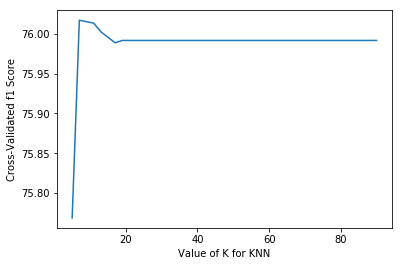

In [76]:
# Preparing list with possible K-values
neighbors = [5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 76, 79, 90]
cv_f1_scores  = []

# Brute force KNN
for i in tqdm(neighbors):
  knn = KNeighborsClassifier(n_neighbors=i, algorithm='brute')
  knn.fit(cv_train_final_tfidf, y_cv_train)
  pred = knn.predict(cv_test_final_tfidf)
  f1 = f1_score(y_cv_test, pred, average='weighted')*100
  cv_f1_scores.append(f1)
  print('CV weighted f1 for k = %d is %f%%' % (i, f1))
  
plt.plot(neighbors, cv_f1_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated f1 Score')

best_k = neighbors[cv_f1_scores.index(max(cv_f1_scores))]
train_error = round((100-max(cv_f1_scores)),4)
print('Best K: ',best_k)

Weighted f1-score for k= 7  is  74.66279147355047 %
Confusion matrix : 
[[   11  4182]
 [   37 19770]]


Text(0.5, 1.0, 'Heatmap for confusion matrix')

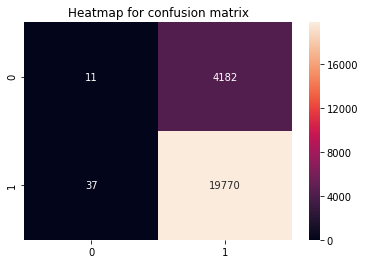

In [77]:
# vectorizing X_train
tf_idf_vect2 = TfidfVectorizer(ngram_range=(1,2))
X_train_final_tfidf = tf_idf_vect2.fit_transform(X_train)
X_train_voc = tf_idf_vect2.vocabulary_

# vectorizing X_test
tf_idf_vect3 = TfidfVectorizer(ngram_range=(1,2), vocabulary = X_train_voc)
X_test_final_tfidf = tf_idf_vect3.fit_transform(X_test)

# appling knn k-dtree bow
knn = KNeighborsClassifier(n_neighbors=best_k, algorithm='brute')
knn.fit(X_train_final_tfidf, y_train)
pred = knn.predict(X_test_final_tfidf)
f1 = f1_score(y_test, pred, average='weighted')*100
test_error = round((100-f1),4)
confusion = confusion_matrix(y_test, pred)
print('Weighted f1-score for k=',best_k,' is ',f1,'%')
print('Confusion matrix : ')
print(confusion)
x.add_row(["TF-IDF - Brute force ", best_k, train_error, test_error])
import seaborn as sns
ax = sns.heatmap(confusion, annot=True, fmt="d") 
ax.set_title('Heatmap for confusion matrix')


In [22]:
# kd-tree KNN for TF-IDF

# Dividing raw train and test data
from sklearn.metrics import f1_score
X = final['CleanedText']
y = np.array(new_labels)

X_train = X[:int(0.7*len(X))]
y_train = y[:int(0.7*len(y))]
X_test = X[len(X_train):]
y_test = y[len(y_train):]

X_cv_train = X_train[:int(0.7*len(X_train))]
y_cv_train = y_train[:int(0.7*len(y_train))]
X_cv_test = X_train[len(X_cv_train):]
y_cv_test = y_train[len(y_cv_train):]

# vectorizing X_cv_train
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
cv_train_final_tfidf = tf_idf_vect.fit_transform(X_cv_train)
X_cv_voc = tf_idf_vect.vocabulary_

# svd on X_cv_train
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300, n_iter=7, random_state=42)
svd.fit(cv_train_final_tfidf)
svd_cv_train_final_tfidf=svd.transform(cv_train_final_tfidf)

# vectorizing X_cv_test
tf_idf_vect2 = TfidfVectorizer(ngram_range=(1,2), vocabulary = X_cv_voc)
cv_test_final_tfidf = tf_idf_vect2.fit_transform(X_cv_test)

# svd on X_cv_test
svd = TruncatedSVD(n_components=300, n_iter=7, random_state=42)
svd.fit(cv_test_final_tfidf)
svd_cv_test_final_tfidf=svd.transform(cv_test_final_tfidf)


print("the type of count vectorizer ",type(cv_train_final_tfidf))
print("the shape of out text TFIDF vectorizer ",cv_train_final_tfidf.get_shape())
print("the number of unique words including both unigrams and bigrams ", cv_train_final_tfidf.get_shape()[1])

features = tf_idf_vect.get_feature_names()
print("some sample features(unique words in the corpus)",features[10:20])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (39200, 645159)
the number of unique words including both unigrams and bigrams  645159
some sample features(unique words in the corpus) ['aafco statement', 'aagh', 'aagh yelp', 'aah', 'aah handsom', 'aah rest', 'aalmost', 'aalmost good', 'ab', 'ab diet']


  5%|▍         | 1/21 [11:36<3:52:09, 696.49s/it]

CV weighted f1 for k = 5 is 74.870043%


 10%|▉         | 2/21 [23:06<3:39:53, 694.40s/it]

CV weighted f1 for k = 7 is 74.993299%


 14%|█▍        | 3/21 [34:39<3:28:15, 694.17s/it]

CV weighted f1 for k = 11 is 75.081355%


 19%|█▉        | 4/21 [46:08<3:16:12, 692.49s/it]

CV weighted f1 for k = 13 is 75.071072%


 24%|██▍       | 5/21 [57:51<3:05:29, 695.61s/it]

CV weighted f1 for k = 17 is 75.091730%


 29%|██▊       | 6/21 [1:09:30<2:54:12, 696.84s/it]

CV weighted f1 for k = 19 is 75.091730%


 33%|███▎      | 7/21 [1:21:10<2:42:46, 697.62s/it]

CV weighted f1 for k = 23 is 75.097630%


 38%|███▊      | 8/21 [1:32:49<2:31:15, 698.15s/it]

CV weighted f1 for k = 29 is 75.097630%


 43%|████▎     | 9/21 [1:44:26<2:19:34, 697.87s/it]

CV weighted f1 for k = 31 is 75.097630%


 48%|████▊     | 10/21 [1:56:02<2:07:49, 697.22s/it]

CV weighted f1 for k = 37 is 75.097630%


 52%|█████▏    | 11/21 [2:07:39<1:56:10, 697.08s/it]

CV weighted f1 for k = 41 is 75.097630%


 57%|█████▋    | 12/21 [2:19:17<1:44:36, 697.41s/it]

CV weighted f1 for k = 43 is 75.097630%


 62%|██████▏   | 13/21 [2:30:59<1:33:09, 698.69s/it]

CV weighted f1 for k = 47 is 75.097630%


 67%|██████▋   | 14/21 [2:42:40<1:21:36, 699.47s/it]

CV weighted f1 for k = 53 is 75.097630%


 71%|███████▏  | 15/21 [2:54:22<1:10:00, 700.14s/it]

CV weighted f1 for k = 59 is 75.097630%


 76%|███████▌  | 16/21 [3:06:46<59:26, 713.39s/it]  

CV weighted f1 for k = 61 is 75.097630%


 81%|████████  | 17/21 [3:19:22<48:25, 726.32s/it]

CV weighted f1 for k = 67 is 75.097630%


 86%|████████▌ | 18/21 [3:31:34<36:24, 728.01s/it]

CV weighted f1 for k = 71 is 75.097630%


 90%|█████████ | 19/21 [3:43:44<24:16, 728.49s/it]

CV weighted f1 for k = 76 is 75.097630%


 95%|█████████▌| 20/21 [3:55:34<12:02, 722.87s/it]

CV weighted f1 for k = 79 is 75.097630%


100%|██████████| 21/21 [4:07:29<00:00, 720.49s/it]

CV weighted f1 for k = 90 is 75.097630%


Best K:  23


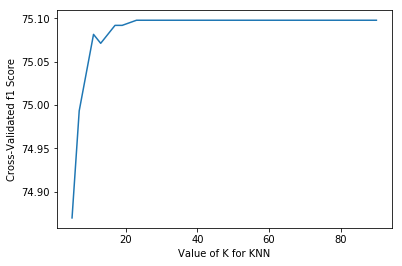

In [23]:
# Preparing list with possible K-values
neighbors = [5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 76, 79, 90]
cv_f1_scores  = []

# kd_tree force KNN
for i in tqdm(neighbors):
  knn = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
  knn.fit(svd_cv_train_final_tfidf, y_cv_train)
  pred = knn.predict(svd_cv_test_final_tfidf)
  f1 = f1_score(y_cv_test, pred, average='weighted')*100
  cv_f1_scores.append(f1)
  print('CV weighted f1 for k = %d is %f%%' % (i, f1))
  
plt.plot(neighbors, cv_f1_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated f1 Score')

best_k = neighbors[cv_f1_scores.index(max(cv_f1_scores))]
train_error = round((100-max(cv_f1_scores)),4)
print('Best K: ',best_k)

Weighted f1-score for k= 23  is  74.10543743471266 %
Confusion matrix : 
[[    0  4283]
 [    0 19717]]


Text(0.5, 1.0, 'Heatmap for confusion matrix')

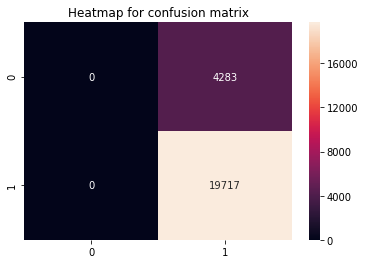

In [24]:
# vectorizing X_train
tf_idf_vect2 = TfidfVectorizer(ngram_range=(1,2))
X_train_final_tfidf = tf_idf_vect2.fit_transform(X_train)
X_train_voc = tf_idf_vect2.vocabulary_

# svd on X_train
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300, n_iter=7, random_state=42)
svd.fit(X_train_final_tfidf)
svd_X_train_final_tfidf=svd.transform(X_train_final_tfidf)

# vectorizing X_test
tf_idf_vect3 = TfidfVectorizer(ngram_range=(1,2), vocabulary = X_train_voc)
X_test_final_tfidf = tf_idf_vect3.fit_transform(X_test)

# svd on X_test
svd = TruncatedSVD(n_components=300, n_iter=7, random_state=42)
svd.fit(X_test_final_tfidf)
svd_X_test_final_tfidf=svd.transform(X_test_final_tfidf)

# appling knn k-dtree bow
knn = KNeighborsClassifier(n_neighbors=best_k, algorithm='kd_tree')
knn.fit(svd_X_train_final_tfidf, y_train)
pred = knn.predict(svd_X_test_final_tfidf)
f1 = f1_score(y_test, pred, average='weighted')*100
test_error = round((100-f1),4)
confusion = confusion_matrix(y_test, pred)
print('Weighted f1-score for k=',best_k,' is ',f1,'%')
print('Confusion matrix : ')
print(confusion)
x.add_row(["TF-IDF - kd_tree ", best_k, train_error, test_error])
import seaborn as sns
ax = sns.heatmap(confusion, annot=True, fmt="d") 
ax.set_title('Heatmap for confusion matrix')


# [7.2.6] Word2Vec

In [21]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need
is_your_ram_gt_16g=False
want_to_read_sub_set_of_google_w2v = True
want_to_read_whole_google_w2v = True
if not is_your_ram_gt_16g:
    if want_to_read_sub_set_of_google_w2v and  os.path.isfile('google_w2v_for_amazon.pkl'):
        with open('google_w2v_for_amazon.pkl', 'rb') as f:
            # model is dict object, you can directly access any word vector using model[word]
            model = pickle.load(f)
else:
    if want_to_read_whole_google_w2v and os.path.isfile('GoogleNews-vectors-negative300.bin'):
        model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

# print("the vector representation of word 'computer'",model.wv['computer'])
# print("the similarity between the words 'woman' and 'man'",model.wv.similarity('woman', 'man'))
# print("the most similar words to the word 'woman'",model.wv.most_similar('woman'))
# this will raise an error
# model.wv.most_similar('tasti')  # "tasti" is the stemmed word for tasty, tastful

## Average W2V

In [22]:
# Dividing raw train and test data
from sklearn.metrics import f1_score
from scipy.sparse import csr_matrix

X = final['CleanedText']
y = np.array(new_labels)

X_train = X[:int(0.7*len(X))]
y_train = y[:int(0.7*len(y))]
X_test = X[len(X_train):]
y_test = y[len(y_train):]

X_cv_train = X_train[:int(0.7*len(X_train))]
y_cv_train = y_train[:int(0.7*len(y_train))]
X_cv_test = X_train[len(X_cv_train):]
y_cv_test = y_train[len(y_cv_train):]

# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent1=[]
for sent in X_cv_train:
    list_of_sent1.append(sent.split())
    
    
print(X_cv_train[0])
print("*****************************************************************")
print(list_of_sent1[0])

easi use make mess offer vibrant color taint decort color would high recommend anyon like decor
*****************************************************************
['easi', 'use', 'make', 'mess', 'offer', 'vibrant', 'color', 'taint', 'decort', 'color', 'would', 'high', 'recommend', 'anyon', 'like', 'decor']


In [23]:
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent1,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  8472
sample words  ['easi', 'use', 'make', 'mess', 'offer', 'vibrant', 'color', 'taint', 'would', 'high', 'recommend', 'anyon', 'like', 'decor', 'much', 'easier', 'wilson', 'past', 'frost', 'simpl', 'complaint', 'find', 'year', 'ago', 'must', 'often', 'michael', 'keaton', 'bring', 'distinguish', 'characterist', 'beetlejuic', 'mere', 'act', 'bizarr', 'script', 'stun', 'movi', 'come', 'focus', 'one', 'snack', 'popcorn', 'two', 'coupl', 'geena', 'davi', 'alec', 'baldwin', 'die']


In [24]:
w2v_model.wv.most_similar('tasti')

[('yummi', 0.7638883590698242),
 ('delici', 0.7609142661094666),
 ('satisfi', 0.6859474182128906),
 ('hearti', 0.683555543422699),
 ('crispi', 0.6527554988861084),
 ('good', 0.6357921957969666),
 ('incred', 0.6317739486694336),
 ('dens', 0.6297272443771362),
 ('crunchi', 0.6285186409950256),
 ('crisp', 0.6279142498970032)]

In [25]:
w2v_model.wv.most_similar('like')

[('hate', 0.6483539342880249),
 ('appeal', 0.6457335352897644),
 ('remind', 0.6283673644065857),
 ('prefer', 0.6212931871414185),
 ('weird', 0.6061646938323975),
 ('good', 0.6032252907752991),
 ('think', 0.5980886220932007),
 ('enjoy', 0.5962779521942139),
 ('terribl', 0.5942579507827759),
 ('okay', 0.5924064517021179)]

In [26]:
# average Word2Vec
# compute average word2vec for each review.
cv_train_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent1): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_train_sent_vectors.append(sent_vec)
cv_train_sent_vectors=csr_matrix(cv_train_sent_vectors)

100%|██████████| 39200/39200 [00:44<00:00, 872.69it/s] 


In [27]:
# vectorzing X_cv_test
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent2=[]
for sent in X_cv_test:
    list_of_sent2.append(sent.split())
    
# average Word2Vec
# compute average word2vec for each review.
cv_test_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent2): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_test_sent_vectors.append(sent_vec)
cv_test_sent_vectors=csr_matrix(cv_test_sent_vectors)
print(cv_test_sent_vectors.shape)

100%|██████████| 16800/16800 [00:13<00:00, 1289.31it/s]

(16800, 50)


  5%|▍         | 1/21 [02:25<48:31, 145.55s/it]

CV weighted f1 for k = 5 is 74.875142%


 10%|▉         | 2/21 [04:48<45:52, 144.87s/it]

CV weighted f1 for k = 7 is 74.682175%


 14%|█▍        | 3/21 [07:13<43:24, 144.72s/it]

CV weighted f1 for k = 11 is 74.725713%


 19%|█▉        | 4/21 [09:36<40:51, 144.22s/it]

CV weighted f1 for k = 13 is 74.760728%


 24%|██▍       | 5/21 [12:01<38:31, 144.48s/it]

CV weighted f1 for k = 17 is 74.753364%


 29%|██▊       | 6/21 [14:24<36:02, 144.17s/it]

CV weighted f1 for k = 19 is 74.753364%


 33%|███▎      | 7/21 [16:48<33:35, 143.96s/it]

CV weighted f1 for k = 23 is 74.739027%


 38%|███▊      | 8/21 [19:12<31:11, 143.98s/it]

CV weighted f1 for k = 29 is 74.739027%


 43%|████▎     | 9/21 [21:35<28:46, 143.86s/it]

CV weighted f1 for k = 31 is 74.739027%


 48%|████▊     | 10/21 [24:00<26:24, 144.07s/it]

CV weighted f1 for k = 37 is 74.739027%


 52%|█████▏    | 11/21 [26:23<23:56, 143.69s/it]

CV weighted f1 for k = 41 is 74.739027%


 57%|█████▋    | 12/21 [28:47<21:35, 143.90s/it]

CV weighted f1 for k = 43 is 74.739027%


 62%|██████▏   | 13/21 [31:11<19:10, 143.86s/it]

CV weighted f1 for k = 47 is 74.739027%


 67%|██████▋   | 14/21 [33:36<16:48, 144.11s/it]

CV weighted f1 for k = 53 is 74.739027%


 71%|███████▏  | 15/21 [35:58<14:22, 143.74s/it]

CV weighted f1 for k = 59 is 74.739027%


 76%|███████▌  | 16/21 [38:22<11:57, 143.58s/it]

CV weighted f1 for k = 61 is 74.739027%


 81%|████████  | 17/21 [40:43<09:31, 142.94s/it]

CV weighted f1 for k = 67 is 74.739027%


 86%|████████▌ | 18/21 [43:07<07:09, 143.13s/it]

CV weighted f1 for k = 71 is 74.739027%


 90%|█████████ | 19/21 [45:28<04:45, 142.72s/it]

CV weighted f1 for k = 76 is 74.739027%


 95%|█████████▌| 20/21 [47:51<02:22, 142.57s/it]

CV weighted f1 for k = 79 is 74.739027%


100%|██████████| 21/21 [50:14<00:00, 142.71s/it]

CV weighted f1 for k = 90 is 74.739027%
Best K:  5


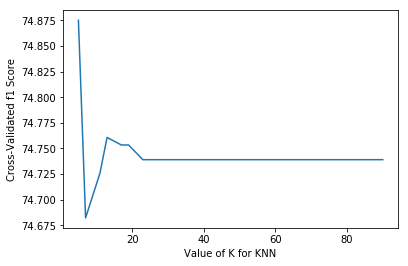

In [28]:
# Preparing list with possible K-values
neighbors = [5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 76, 79, 90]
cv_f1_scores  = []

# kd_tree force KNN
for i in tqdm(neighbors):
  knn = KNeighborsClassifier(n_neighbors=i, algorithm='brute')
  knn.fit(cv_train_sent_vectors, y_cv_train)
  pred = knn.predict(cv_test_sent_vectors)
  f1 = f1_score(y_cv_test, pred, average='weighted')*100
  cv_f1_scores.append(f1)
  print('CV weighted f1 for k = %d is %f%%' % (i, f1))
  
plt.plot(neighbors, cv_f1_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated f1 Score')

best_k = neighbors[cv_f1_scores.index(max(cv_f1_scores))]
train_error = round((100-max(cv_f1_scores)),4)
print('Best K: ',best_k)

In [29]:
# vectorizing X_train


# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent3=[]
for sent in X_train:
    list_of_sent3.append(sent.split())
    
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent3,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)


# average Word2Vec
# compute average word2vec for each review.
X_train_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent3): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_sent_vectors.append(sent_vec)
X_train_sent_vectors=csr_matrix(X_train_sent_vectors)
print(X_train_sent_vectors.shape)

100%|██████████| 56000/56000 [01:02<00:00, 902.23it/s] 


(56000, 50)


In [30]:
# vectorizing X_test


# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent4=[]
for sent in X_test:
    list_of_sent4.append(sent.split())
    
# average Word2Vec
# compute average word2vec for each review.
X_test_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent4): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_sent_vectors.append(sent_vec)

X_test_sent_vectors=csr_matrix(X_test_sent_vectors)
print(X_test_sent_vectors.shape)


100%|██████████| 24000/24000 [00:20<00:00, 1173.74it/s]


(24000, 50)


Weighted f1-score for k= 5  is  74.94285887277073 %
Confusion matrix : 
[[   56  4062]
 [  312 19570]]


Text(0.5, 1.0, 'Heatmap for confusion matrix')

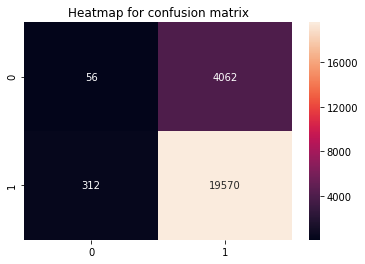

In [31]:
# appling knn brute force on average word2vec
knn = KNeighborsClassifier(n_neighbors=best_k, algorithm='brute')
knn.fit(X_train_sent_vectors, y_train)
pred = knn.predict(X_test_sent_vectors)
f1 = f1_score(y_test, pred, average='weighted')*100
test_error = round((100-f1),4)
confusion = confusion_matrix(y_test, pred)
print('Weighted f1-score for k=',best_k,' is ',f1,'%')
print('Confusion matrix : ')
print(confusion)
x.add_row(["Average Word2Vec Brute force", best_k, train_error, test_error])
import seaborn as sns
ax = sns.heatmap(confusion, annot=True, fmt="d") 
ax.set_title('Heatmap for confusion matrix')


In [32]:
# kd-tree KNN on Average W2V

# Dividing raw train and test data
from sklearn.metrics import f1_score
X = final['CleanedText']
y = np.array(new_labels)

X_train = X[:int(0.7*len(X))]
y_train = y[:int(0.7*len(y))]
X_test = X[len(X_train):]
y_test = y[len(y_train):]

X_cv_train = X_train[:int(0.7*len(X_train))]
y_cv_train = y_train[:int(0.7*len(y_train))]
X_cv_test = X_train[len(X_cv_train):]
y_cv_test = y_train[len(y_cv_train):]

# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent1=[]
for sent in X_cv_train:
    list_of_sent1.append(sent.split())
    
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent1,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)

# average Word2Vec
# compute average word2vec for each review.
cv_train_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent1): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_train_sent_vectors.append(sent_vec)

cv_train_sent_vectors=csr_matrix(cv_train_sent_vectors)
cv_train_sent_vectors=cv_train_sent_vectors.todense()

print(len(cv_train_sent_vectors))


100%|██████████| 39200/39200 [00:42<00:00, 927.88it/s] 


39200


In [33]:
# vectorzing X_cv_test
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent2=[]
for sent in X_cv_test:
    list_of_sent2.append(sent.split())

# average Word2Vec
# compute average word2vec for each review.
cv_test_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent2): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    cv_test_sent_vectors.append(sent_vec)
    
cv_test_sent_vectors=csr_matrix(cv_test_sent_vectors)
cv_test_sent_vectors=cv_test_sent_vectors.todense()
print(len(cv_test_sent_vectors))


100%|██████████| 16800/16800 [00:12<00:00, 1351.74it/s]


16800


  5%|▍         | 1/21 [03:19<1:06:22, 199.11s/it]

CV weighted f1 for k = 5 is 74.531431%


 10%|▉         | 2/21 [06:36<1:02:53, 198.59s/it]

CV weighted f1 for k = 7 is 74.720680%


 14%|█▍        | 3/21 [09:51<59:13, 197.40s/it]  

CV weighted f1 for k = 11 is 74.787860%


 19%|█▉        | 4/21 [13:08<55:53, 197.28s/it]

CV weighted f1 for k = 13 is 74.760728%


 24%|██▍       | 5/21 [16:23<52:27, 196.74s/it]

CV weighted f1 for k = 17 is 74.750410%


 29%|██▊       | 6/21 [19:38<49:03, 196.24s/it]

CV weighted f1 for k = 19 is 74.753364%


 33%|███▎      | 7/21 [22:55<45:50, 196.46s/it]

CV weighted f1 for k = 23 is 74.739027%


 38%|███▊      | 8/21 [26:12<42:33, 196.46s/it]

CV weighted f1 for k = 29 is 74.739027%


 43%|████▎     | 9/21 [29:29<39:20, 196.74s/it]

CV weighted f1 for k = 31 is 74.739027%


 48%|████▊     | 10/21 [32:43<35:54, 195.88s/it]

CV weighted f1 for k = 37 is 74.739027%


 52%|█████▏    | 11/21 [35:57<32:34, 195.43s/it]

CV weighted f1 for k = 41 is 74.739027%


 57%|█████▋    | 12/21 [39:14<29:22, 195.80s/it]

CV weighted f1 for k = 43 is 74.739027%


 62%|██████▏   | 13/21 [42:30<26:07, 195.98s/it]

CV weighted f1 for k = 47 is 74.739027%


 67%|██████▋   | 14/21 [45:44<22:48, 195.44s/it]

CV weighted f1 for k = 53 is 74.739027%


 71%|███████▏  | 15/21 [49:02<19:36, 196.02s/it]

CV weighted f1 for k = 59 is 74.739027%


 76%|███████▌  | 16/21 [52:17<16:18, 195.75s/it]

CV weighted f1 for k = 61 is 74.739027%


 81%|████████  | 17/21 [55:36<13:07, 196.83s/it]

CV weighted f1 for k = 67 is 74.739027%


 86%|████████▌ | 18/21 [58:56<09:52, 197.56s/it]

CV weighted f1 for k = 71 is 74.739027%


 90%|█████████ | 19/21 [1:02:12<06:34, 197.29s/it]

CV weighted f1 for k = 76 is 74.739027%


 95%|█████████▌| 20/21 [1:05:30<03:17, 197.51s/it]

CV weighted f1 for k = 79 is 74.739027%


100%|██████████| 21/21 [1:08:49<00:00, 197.92s/it]

CV weighted f1 for k = 90 is 74.739027%
Best K:  11


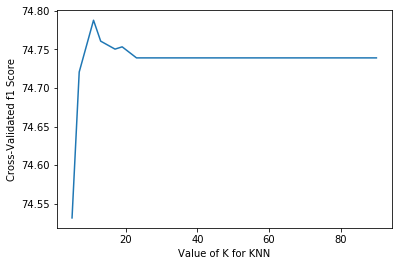

In [34]:
# Preparing list with possible K-values
neighbors = [5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 76, 79, 90]
cv_f1_scores  = []

# kd_tree force KNN
for i in tqdm(neighbors):
  knn = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
  knn.fit(cv_train_sent_vectors, y_cv_train)
  pred = knn.predict(cv_test_sent_vectors)
  f1 = f1_score(y_cv_test, pred, average='weighted')*100
  cv_f1_scores.append(f1)
  print('CV weighted f1 for k = %d is %f%%' % (i, f1))
  
plt.plot(neighbors, cv_f1_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated f1 Score')

best_k = neighbors[cv_f1_scores.index(max(cv_f1_scores))]
train_error = round((100-max(cv_f1_scores)),4)
print('Best K: ',best_k)

In [35]:
# vectorizing X_train


# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent3=[]
for sent in X_train:
    list_of_sent3.append(sent.split())
    
# min_count = 5 considers only words that occured atleast 5 times
w2v_model=Word2Vec(list_of_sent3,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model.wv.vocab)


# average Word2Vec
# compute average word2vec for each review.
X_train_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent3): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_sent_vectors.append(sent_vec)
    
X_train_sent_vectors=csr_matrix(X_train_sent_vectors)
X_train_sent_vectors=X_train_sent_vectors.todense()
print(len(X_train_sent_vectors))


100%|██████████| 56000/56000 [01:00<00:00, 921.23it/s] 


56000


In [36]:
# vectorizing X_test


# Train your own Word2Vec model using your own text corpus
i=0
list_of_sent4=[]
for sent in X_test:
    list_of_sent4.append(sent.split())
    

# average Word2Vec
# compute average word2vec for each review.
X_test_sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent4): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_sent_vectors.append(sent_vec)
    
X_test_sent_vectors=csr_matrix(X_test_sent_vectors)
X_test_sent_vectors=X_test_sent_vectors.todense()
print(len(X_test_sent_vectors))


100%|██████████| 24000/24000 [00:20<00:00, 1148.95it/s]


24000


Weighted f1-score for k= 11  is  75.06662891884454 %
Confusion matrix : 
[[    3  4115]
 [   15 19867]]


Text(0.5, 1.0, 'Heatmap for confusion matrix')

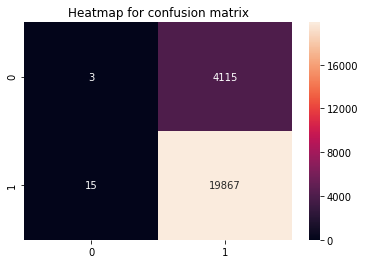

In [37]:
# appling knn kd_tree on average word2vec
knn = KNeighborsClassifier(n_neighbors=best_k, algorithm='kd_tree')
knn.fit(X_train_sent_vectors, y_train)
pred = knn.predict(X_test_sent_vectors)
f1 = f1_score(y_test, pred, average='weighted')*100
test_error = round((100-f1),4)
confusion = confusion_matrix(y_test, pred)
print('Weighted f1-score for k=',best_k,' is ',f1,'%')
print('Confusion matrix : ')
print(confusion)
x.add_row(["Average Word2Vec - kd_tree ", best_k, train_error, test_error])
import seaborn as sns
ax = sns.heatmap(confusion, annot=True, fmt="d") 
ax.set_title('Heatmap for confusion matrix')


# TFIDF-W2V

In [38]:
# Dividing raw train and test data
from sklearn.metrics import f1_score
X = final['CleanedText']
y = np.array(new_labels)

X_train = X[:int(0.7*len(X))]
y_train = y[:int(0.7*len(y))]
X_test = X[len(X_train):]
y_test = y[len(y_train):]

X_cv_train = X_train[:int(0.7*len(X_train))]
y_cv_train = y_train[:int(0.7*len(y_train))]
X_cv_test = X_train[len(X_cv_train):]
y_cv_test = y_train[len(y_cv_train):]

i=0
list_of_sent=[]
for sent in X_cv_train:
    list_of_sent.append(sent.split())

model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_cv_train)
cv_train_tfidf_voc =model.vocabulary_
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [39]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

cv_train_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    cv_train_tfidf_sent_vectors.append(sent_vec)
    row += 1
    
cv_train_sent_vectors=csr_matrix(cv_train_sent_vectors)


100%|██████████| 39200/39200 [16:17<00:00, 40.11it/s]


In [40]:
i=0
list_of_sent4=[]
for sent in X_cv_test:
    list_of_sent4.append(sent.split())


cv_test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent4): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    cv_test_tfidf_sent_vectors.append(sent_vec)
    row += 1
    
cv_test_sent_vectors=csr_matrix(cv_test_sent_vectors)


100%|██████████| 16800/16800 [06:44<00:00, 41.52it/s]


CV weighted f1 for k = 5 is 74.739027%
CV weighted f1 for k = 7 is 74.739027%
CV weighted f1 for k = 11 is 74.739027%
CV weighted f1 for k = 13 is 74.739027%
CV weighted f1 for k = 17 is 74.739027%
CV weighted f1 for k = 19 is 74.739027%
CV weighted f1 for k = 23 is 74.739027%
CV weighted f1 for k = 29 is 74.739027%
CV weighted f1 for k = 31 is 74.739027%
CV weighted f1 for k = 37 is 74.739027%
CV weighted f1 for k = 41 is 74.739027%
CV weighted f1 for k = 43 is 74.739027%
CV weighted f1 for k = 47 is 74.739027%
CV weighted f1 for k = 53 is 74.739027%
CV weighted f1 for k = 59 is 74.739027%
CV weighted f1 for k = 61 is 74.739027%
CV weighted f1 for k = 67 is 74.739027%
CV weighted f1 for k = 71 is 74.739027%
CV weighted f1 for k = 76 is 74.739027%
CV weighted f1 for k = 79 is 74.739027%
CV weighted f1 for k = 90 is 74.739027%
Best K:  5


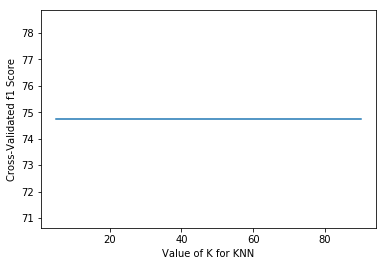

In [41]:
# Preparing list with possible K-values
neighbors = [5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 76, 79, 90]
cv_f1_scores  = []

# brute force KNN
for i in neighbors:
  knn = KNeighborsClassifier(n_neighbors=i, algorithm='brute')
  knn.fit(cv_train_tfidf_sent_vectors, y_cv_train)
  pred = knn.predict(cv_test_tfidf_sent_vectors)
  f1 = f1_score(y_cv_test, pred, average='weighted')*100
  cv_f1_scores.append(f1)
  print('CV weighted f1 for k = %d is %f%%' % (i, f1))
  
plt.plot(neighbors, cv_f1_scores)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated f1 Score')

best_k = neighbors[cv_f1_scores.index(max(cv_f1_scores))]
train_error = round((100-max(cv_f1_scores)),4)
print('Best K: ',best_k)

In [42]:
i=0
list_of_sent=[]
for sent in X_train:
    list_of_sent.append(sent.split())

model2 = TfidfVectorizer()
tf_idf_matrix = model2.fit_transform(X_train)
X_train_tfidf_voc =model2.vocabulary_
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model2.get_feature_names(), list(model2.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model2.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_train_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tfidf_sent_vectors.append(sent_vec)
    row += 1
    
X_train_sent_vectors=csr_matrix(X_train_sent_vectors)


100%|██████████| 56000/56000 [23:20<00:00, 39.99it/s]


In [43]:
i=0
list_of_sent4=[]
for sent in X_test:
    list_of_sent4.append(sent.split())

X_test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tfidf_sent_vectors.append(sent_vec)
    row += 1
    
X_test_sent_vectors=csr_matrix(X_test_sent_vectors)


100%|██████████| 24000/24000 [09:48<00:00, 40.75it/s]


Weighted f1-score for k= 5  is  75.06759111556751 %
Confusion matrix : 
[[    0  4118]
 [    0 19882]]


Text(0.5, 1.0, 'Heatmap for confusion matrix')

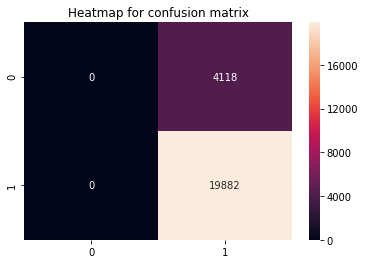

In [44]:
# appling knn brute force on average word2vec
knn = KNeighborsClassifier(n_neighbors=best_k, algorithm='brute')
knn.fit(X_train_tfidf_sent_vectors, y_train)
pred = knn.predict(X_test_tfidf_sent_vectors)
f1 = f1_score(y_test, pred, average='weighted')*100
test_error = round((100-f1),4)
confusion = confusion_matrix(y_test, pred)
print('Weighted f1-score for k=',best_k,' is ',f1,'%')
print('Confusion matrix : ')
print(confusion)
x.add_row(["TF-IDF Weighted W2V - Brute force ", best_k, train_error, test_error])
import seaborn as sns
ax = sns.heatmap(confusion, annot=True, fmt="d") 
ax.set_title('Heatmap for confusion matrix')


In [ ]:
#knn for tfidf weighted w2v kd_tree

In [45]:
# Dividing raw train and test data
from sklearn.metrics import f1_score
X = final['CleanedText']
y = np.array(new_labels)

X_train = X[:int(0.7*len(X))]
y_train = y[:int(0.7*len(y))]
X_test = X[len(X_train):]
y_test = y[len(y_train):]

X_cv_train = X_train[:int(0.7*len(X_train))]
y_cv_train = y_train[:int(0.7*len(y_train))]
X_cv_test = X_train[len(X_cv_train):]
y_cv_test = y_train[len(y_cv_train):]

i=0
list_of_sent=[]
for sent in X_cv_train:
    list_of_sent.append(sent.split())
    
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_cv_train)
cv_train_tfidf_voc =model.vocabulary_
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [46]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

cv_train_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    cv_train_tfidf_sent_vectors.append(sent_vec)
    row += 1
    
cv_train_sent_vectors=csr_matrix(cv_train_sent_vectors)
cv_train_sent_vectors=cv_train_sent_vectors.todense()

100%|██████████| 39200/39200 [15:35<00:00, 41.92it/s]


In [47]:
i=0
list_of_sent=[]
for sent in X_cv_test:
    list_of_sent4.append(sent.split())

cv_test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    cv_test_tfidf_sent_vectors.append(sent_vec)
    row += 1
    
cv_test_sent_vectors=csr_matrix(cv_test_sent_vectors)
cv_test_sent_vectors=cv_test_sent_vectors.todense()

100%|██████████| 16800/16800 [06:46<00:00, 41.36it/s]


CV weighted f1 for k = 5 is 74.739027%
CV weighted f1 for k = 7 is 74.739027%
CV weighted f1 for k = 11 is 74.739027%
CV weighted f1 for k = 13 is 74.739027%
CV weighted f1 for k = 17 is 74.739027%
CV weighted f1 for k = 19 is 74.739027%
CV weighted f1 for k = 23 is 74.739027%
CV weighted f1 for k = 29 is 74.739027%
CV weighted f1 for k = 31 is 74.739027%
CV weighted f1 for k = 37 is 74.739027%
CV weighted f1 for k = 41 is 74.739027%
CV weighted f1 for k = 43 is 74.739027%
CV weighted f1 for k = 47 is 74.739027%
CV weighted f1 for k = 53 is 74.739027%
CV weighted f1 for k = 59 is 74.739027%
CV weighted f1 for k = 61 is 74.739027%
CV weighted f1 for k = 67 is 74.739027%
CV weighted f1 for k = 71 is 74.739027%
CV weighted f1 for k = 76 is 74.739027%
CV weighted f1 for k = 79 is 74.739027%
CV weighted f1 for k = 90 is 74.739027%
Best K:  5


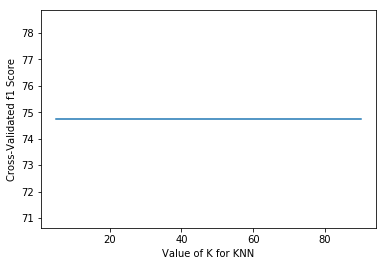

In [48]:
# Preparing list with possible K-values
neighbors = [5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 76, 79, 90]
cv_f1_scores  = []

# kd_tree KNN
for i in neighbors:
  knn = KNeighborsClassifier(n_neighbors=i, algorithm='kd_tree')
  knn.fit(cv_train_tfidf_sent_vectors, y_cv_train)
  pred = knn.predict(cv_test_tfidf_sent_vectors)
  f1 = f1_score(y_cv_test, pred, average='weighted')*100
  cv_f1_scores.append(f1)
  print('CV weighted f1 for k = %d is %f%%' % (i, f1))
  
plt.plot(neighbors, cv_f1_scores)
train_error = round((100-max(cv_f1_scores)),4)
plt.xlabel('Value of K for KNN')
plt.ylabel('Cross-Validated f1 Score')

best_k = neighbors[cv_f1_scores.index(max(cv_f1_scores))]
print('Best K: ',best_k)

In [49]:
i=0
list_of_sent4=[]
for sent in X_train:
    list_of_sent4.append(sent.split())

model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(X_train)
X_train_tfidf_voc =model.vocabulary_
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

X_train_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent4): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tfidf_sent_vectors.append(sent_vec)
    row += 1
    
X_train_sent_vectors=csr_matrix(X_train_sent_vectors)
X_train_sent_vectors=X_train_sent_vectors.todense()

100%|██████████| 56000/56000 [22:22<00:00, 41.72it/s]


In [50]:
i=0
list_of_sent=[]
for sent in X_test:
    list_of_sent.append(sent.split())

X_test_tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(lsit_of_sent): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            #tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tfidf_sent_vectors.append(sent_vec)
    row += 1
    
X_test_sent_vectors=csr_matrix(X_test_sent_vectors)
X_test_sent_vectors=X_test_sent_vectors.todense()

100%|██████████| 24000/24000 [09:49<00:00, 40.70it/s]


Weighted f1-score for k= 5  is  75.06759111556751 %
Confusion matrix : 
[[    0  4118]
 [    0 19882]]


Text(0.5, 1.0, 'Heatmap for confusion matrix')

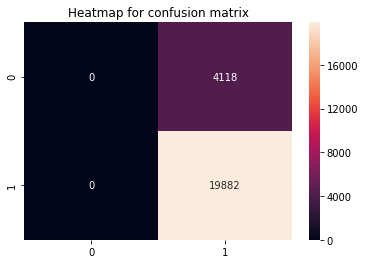

In [51]:
# appling knn kd_tree force on average word2vec
knn = KNeighborsClassifier(n_neighbors=best_k, algorithm='kd_tree')
knn.fit(X_train_tfidf_sent_vectors, y_train)
pred = knn.predict(X_test_tfidf_sent_vectors)
f1 = f1_score(y_test, pred, average='weighted')*100
test_error = round((100-f1),4)
confusion = confusion_matrix(y_test, pred)
print('Weighted f1-score for k=',best_k,' is ',f1,'%')
print('Confusion matrix : ')
print(confusion)
x.add_row(["TF-IDF Weighted W2V - kd_tree ", best_k, train_error, test_error])
import seaborn as sns
ax = sns.heatmap(confusion, annot=True, fmt="d") 
ax.set_title('Heatmap for confusion matrix')


## **OBSERVATION**

In [2]:
print(x)

+-----------------------------------+-------------------+---------------+--------------+
|           Featurization           | Hyperparameter(K) | Train Error % | Test Error % |
+-----------------------------------+-------------------+---------------+--------------+
|     Bag of Words - Brute Force    |         5         |    22.2282    |   23.2249    |
|       Bag of Words - kd_tree      |         23        |    24.0165    |   25.4226    |
|        TF-IDF - Brute Force       |         7         |    23.9828    |    25.332    |
|          TF-IDF - kd_tree         |         23        |    24.9024    |   25.8946    |
|     Avg Word2Vec - Brute Force    |         5         |    25.1249    |   25.0572    |
|       Avg Word2Vec - kd_tree      |         11        |    25.2122    |   24.9334    |
| TF_IDF weighted W2V - Brute Force |         5         |     25.261    |   24.9324    |
|   TF_IDF weighted W2V - kd_tree   |         5         |     25.261    |   24.9324    |
+--------------------

From the above observation table, the best hyperparameter (K) for KNN lies in the range of 5 and 23 with 5 appearing many times. So, the best K might lie between 5 and 23.
If we compare the test errors of all the brute force and kd_tree approaches, kd_tree is giving more error than brute force and for brute force of all featurizations, best k lies between 5 and 7 with 5 repeated thrice.
The lowest error rate we got for Bag of Words with brute force approach is 23.2249. Total number of datapoints used for this application is 80k and simple cross validation is employed.